In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
import skimage.io
import skimage.filters
import time
from scipy.io import savemat
from pathlib import Path

from scipy.spatial.transform import Rotation as R


from tqdm import tqdm

#Allow parallel processing
from p_tqdm import p_map

import centroide_images
import ephemeride
import rayleigh

import csv

In [16]:
def cart2sph2(x,y,z):
    """
    Input: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.
    Output: Two NumPy arrays with the n coordinates in azimuth and zenith angle, in radians, 
    using the convention that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    """
    azimuth = np.arctan2(y,x)
    zenith_angle = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, zenith_angle


def sph2cart2(azimuth,zenith_angle):
    """
    Input: Two NumPy arrays with n coordinates in azimuth and zenith angle, in radians, with the convention 
    that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    Output: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.

    """
    x = np.cos(np.pi/2-zenith_angle) * np.cos(azimuth)
    y = np.cos(np.pi/2-zenith_angle) * np.sin(azimuth)
    z = np.sin(np.pi/2-zenith_angle)
    return x, y, z

def average_angle(angle1,angle2):
    x=np.cos(angle1)+np.cos(angle2)
    y=np.sin(angle1)+np.sin(angle2)
    return np.arctan2(y,x)

def rebin(arr, new_shape): #https://scipython.com/blog/binning-a-2d-array-in-numpy/
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f,XCoeff,YCoeff):
    theta2=(np.hypot(((centroides[:,1]-y_0)*XCoeff),((centroides[:,0]-x_0)*YCoeff))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0)*YCoeff,(centroides[:,1]-y_0)*XCoeff)
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

def average_angle(angle1,angle2):
    x=np.cos(angle1)+np.cos(angle2)
    y=np.sin(angle1)+np.sin(angle2)
    return np.arctan2(y,x)

couleur=3 #is blue
# 0 : R     1 : G
# 2 : G     3 : B

theta=np.load(calib_path+"theta_crop.npy")
alpha=np.load(calib_path+"alpha_crop.npy")
rot_mat=np.load(calib_path+"rot_mat.npy")
Psi = alpha
Theta = theta

theta_0=theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
theta_90=theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
theta_45=theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
theta_135=theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))

degrees=np.pi/180

# Define the path of the .npy file containing the images

In [3]:
in_path="/Users/viollet/Downloads/dataverse_files/"
calib_path="/Users/viollet/Documents/PRO/SunPol/PolarizedDatabaseM/calib/"
out_path="/Users/viollet/Downloads/dataverse_files/processed/"
limit_Zenith_Angle=np.pi*0.5 #Limit Zenith Angle to crop circularly data inside of camera field-of-view.

In [4]:
dirs = os.listdir( in_path ) # Listing Files
dirs_files=[]
for file in dirs:
    if file[-7:]=='raw.npy': # Keeping only ones with ".npy" files. 
        dirs_files.append(file)
dirs_files.sort() #We sort the files in alphabetical order. 
# Since the format is YYYY-MM-DDTHH-mm-ss.npy, the files are sorted in chronological order.
print(dirs_files)
print(dirs)
print(file[-7:])

['2022-07-22_raw.npy']
['2022-07-22_raw_annotations.npy', '2022-07-22_raw.npy', '.DS_Store', 'MANIFEST.TXT', 'processed']
ocessed


In [5]:
#Camera color-polarization pattern
#definition of which color of the pixel is used for simple figure example

couleur=3 #is blue
# 0 : R     1 : G
# 2 : G     3 : B
#definition of which polarizer orientation is used
# indice_pol=0 is 0°
# 0 :  0°   1 : 45°
# 2 : 135°  3 : 90°
#0° -> Vertical polarization

#Load parameters from calibrations files
[crop_x_min,crop_x_max,crop_y_min,crop_y_max]=np.load(calib_path+"params_crop.npy")
(XSensor,YSensor)=(crop_x_min-crop_x_max,crop_y_max-crop_y_min) # Cropped sensor size en pixels*pixels

dist_center=np.load(calib_path+'dist_center.npy') #[1.215145972506110e+03,1.030433565024923e+03]
x_0,y_0=dist_center[0]-crop_x_min,dist_center[1]-crop_y_min #Cropped images optical center of distorsion.


eph=ephemeride.ephemerides() #Initialisation of ephemerids class to get ephemerids figure.

# Load an image

File used : /Users/viollet/Downloads/dataverse_files/2022-07-22_raw.npy
(780, 4)
[array([[944, 800, 496, ..., 336, 256, 208],
        [944, 944, 496, ..., 224, 208, 160],
        [592, 624, 368, ..., 224, 336, 176],
        ...,
        [336, 464, 384, ..., 496, 128, 304],
        [176, 192, 144, ..., 416, 208, 432],
        [224, 256, 208, ..., 272, 176, 304]], dtype=uint16) 1000.032
 '2022-07-22T07-32-02' 8]


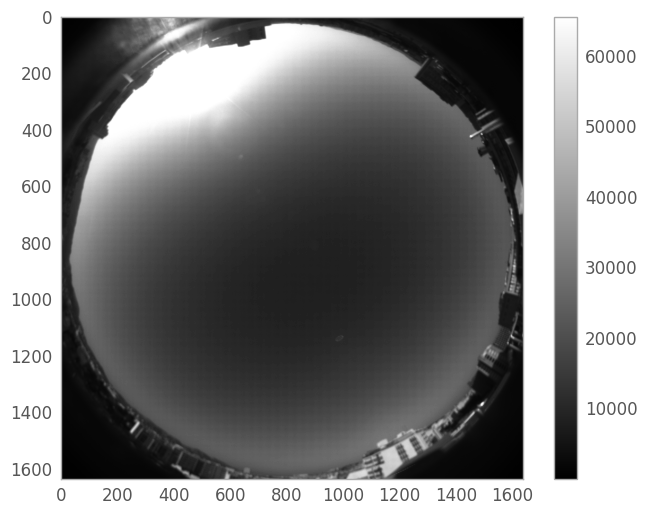

In [6]:
print("File used :",in_path+dirs_files[0])
images_pola=np.load(in_path+dirs_files[0],allow_pickle=True)
print(images_pola.shape)
#print(image_pola[1].shape)
image_pola=images_pola[100]

print(image_pola)
plt.imshow(image_pola[0],cmap='gray')
plt.grid(False)
plt.colorbar()

In [17]:
couleur=3 #is blue
# 0 : R     1 : G
# 2 : G     3 : B

theta=np.load(calib_path+"theta_crop.npy")
alpha=np.load(calib_path+"alpha_crop.npy")
Psi = alpha
Theta = theta

chainetps=image_pola[2]
chainedate=chainetps.split('T')[0]
chemin_enreg=out_path+chainedate+'/'

#Export Matlab format
mdict = { 'Psi2' : Psi, 'Theta2' : Theta}
#file_path = os.path.join(chemin_enreg + "/")
#print(file_path)
savemat(chemin_enreg+"Param_cam2.mat", mdict)

#Smart cropping of the particle matrix (Psi,Theta) to make the size equal to AoP and DoP matrices
alpha_0=Psi[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
alpha_90=Psi[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
alpha_45=Psi[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
alpha_135=Psi[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
alpha_mini=average_angle(average_angle(alpha_0,alpha_90),average_angle(alpha_45,alpha_135))    
theta_0=Theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
theta_90=Theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
theta_45=Theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
theta_135=Theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))
    
Psi=alpha_mini#rebin(alpha,(alpha.shape[0]//4,alpha.shape[1]//4))
Theta=theta_mini#rebin(theta,(theta.shape[0]//4,theta.shape[1]//4)) 

In [18]:
theta=np.load(calib_path+"theta_crop.npy")
alpha=np.load(calib_path+"alpha_crop.npy")
f=float(np.load(calib_path+"f.npy"))
rot_mat=np.load(calib_path+"rot_mat.npy")
print(theta.shape)
print(alpha.shape)
r = R.from_matrix(rot_mat)
r.as_euler('zxy')
print(r.as_euler('zxy'))

chainetps=image_pola[2]
chainedate=chainetps.split('T')[0]
chemin_enreg=out_path+chainedate+'/'

#Export Matlab format
mdict = { 'Psi' : Psi, 'Theta' : Theta, 'Focal' : f, 'Rot_ENU_cam' : rot_mat}
#file_path = os.path.join(chemin_enreg + "/")
#print(file_path)
savemat(chemin_enreg+"Param_cam.mat", mdict)
print(f)

(1636, 1636)
(1636, 1636)
[-2.35643828  0.03262081 -0.0358364 ]
519.5310140736501



# Visualization of the image, solar ephemerids, AoP and DoP. Comparison between calculated and measured values.

In [19]:
def visualize(image_pola, save=False):    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps) 
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])
        
    #Calculation of stokes parameters and of AOP and DOP    
    Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
    U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
    I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
    ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
    #ksi=np.subtract(ksi,Psi*180/np.pi)
    
    ksi[theta_mini>limit_Zenith_Angle]=0
            
    print("Creation figure ...")
    fig,(ax1,ax2)=plt.subplots(2,3,figsize=(20,12),gridspec_kw={'width_ratios':[0.95,1.2,1.2]})

    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
            
        
    print("plot aop image...")
    pcm1=ax2[1].pcolormesh(ksi,cmap='hsv')
    ax2[1].set_title("Measured AOP")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbar=fig.colorbar(pcm1,ax=ax2[1],shrink=0.9)
    cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
    cbar.set_label("Angle of Polarization (°)")
    ax2[1].invert_yaxis()

    print("plot dop image...")
    DOP_dofp=np.hypot(Q,U)/I 
    DOP_dofp[theta_mini>limit_Zenith_Angle]=0
    pcm3=ax2[2].pcolormesh(np.minimum(DOP_dofp,1),cmap='jet',vmin=0.0, vmax=1.0)
    ax2[2].set_title("Measured DOP")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbardop=fig.colorbar(pcm3,ax=ax2[2],shrink=0.9)
    pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
    cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbardop.set_label("Degree of Polarization")
    ax2[2].invert_yaxis()

    print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    imageRGB = (np.stack([a[0::2,0::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax2[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax2[0],shrink=0.9)
    ax2[0].set_aspect('equal')
    ax2[0].set_title("RGB Image")  
      
    d=np.pi/180
    r = R.from_matrix(rot_mat)
            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    #x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
                           
    print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax1[0])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
            
    print("plot simul rayleigh...")
    
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax1[1],ax_dop=ax1[2],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat,limit_Zenith_Angle=limit_Zenith_Angle)#orientation_pixels_ENU=orientation_ENU)

    if (save) :
        #Save in matlab format : .mat
        mdict = { 'AOPs_'+str(["R","Gr","Gb","B"][couleur]) : AOP_s}
        file_path = os.path.join(chemin_enreg, chainetps + "/")
        #print(file_path)
        savemat(file_path+"AOPs_"+str(["R","Gr","Gb","B"][couleur])+".mat", mdict)

        #Save in matlab format : .mat
        mdict = { 'DOPs_'+str(["R","Gr","Gb","B"][couleur]) : DOP_s}
        file_path = os.path.join(chemin_enreg, chainetps + "/")
        savemat(file_path+"DOPs_"+str(["R","Gr","Gb","B"][couleur])+".mat", mdict)
    
    ax2[1].invert_yaxis()
    ax2[2].invert_yaxis()            

          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
    ax2[0].axis('scaled')
    ax2[1].axis('scaled')
    ax2[2].axis('scaled')
    ax1[1].axis('scaled')
    ax1[2].axis('scaled')
    cbarrgb.remove()
    return (U,Q,I,ksi,DOP_dofp,fig)

Creation figure ...
plot aop image...
plot dop image...
plot rgb image...
Psi_sun : 1.2721685551243926 Theta_sun : 1.370276012643807
Sun_rot[0] : -1.0929145698159288 Sun_rot[1] : 1.382559466298503
plot ephemeride...
plot simul rayleigh...
2022-07-22T07-32-02
1.5707963267948966


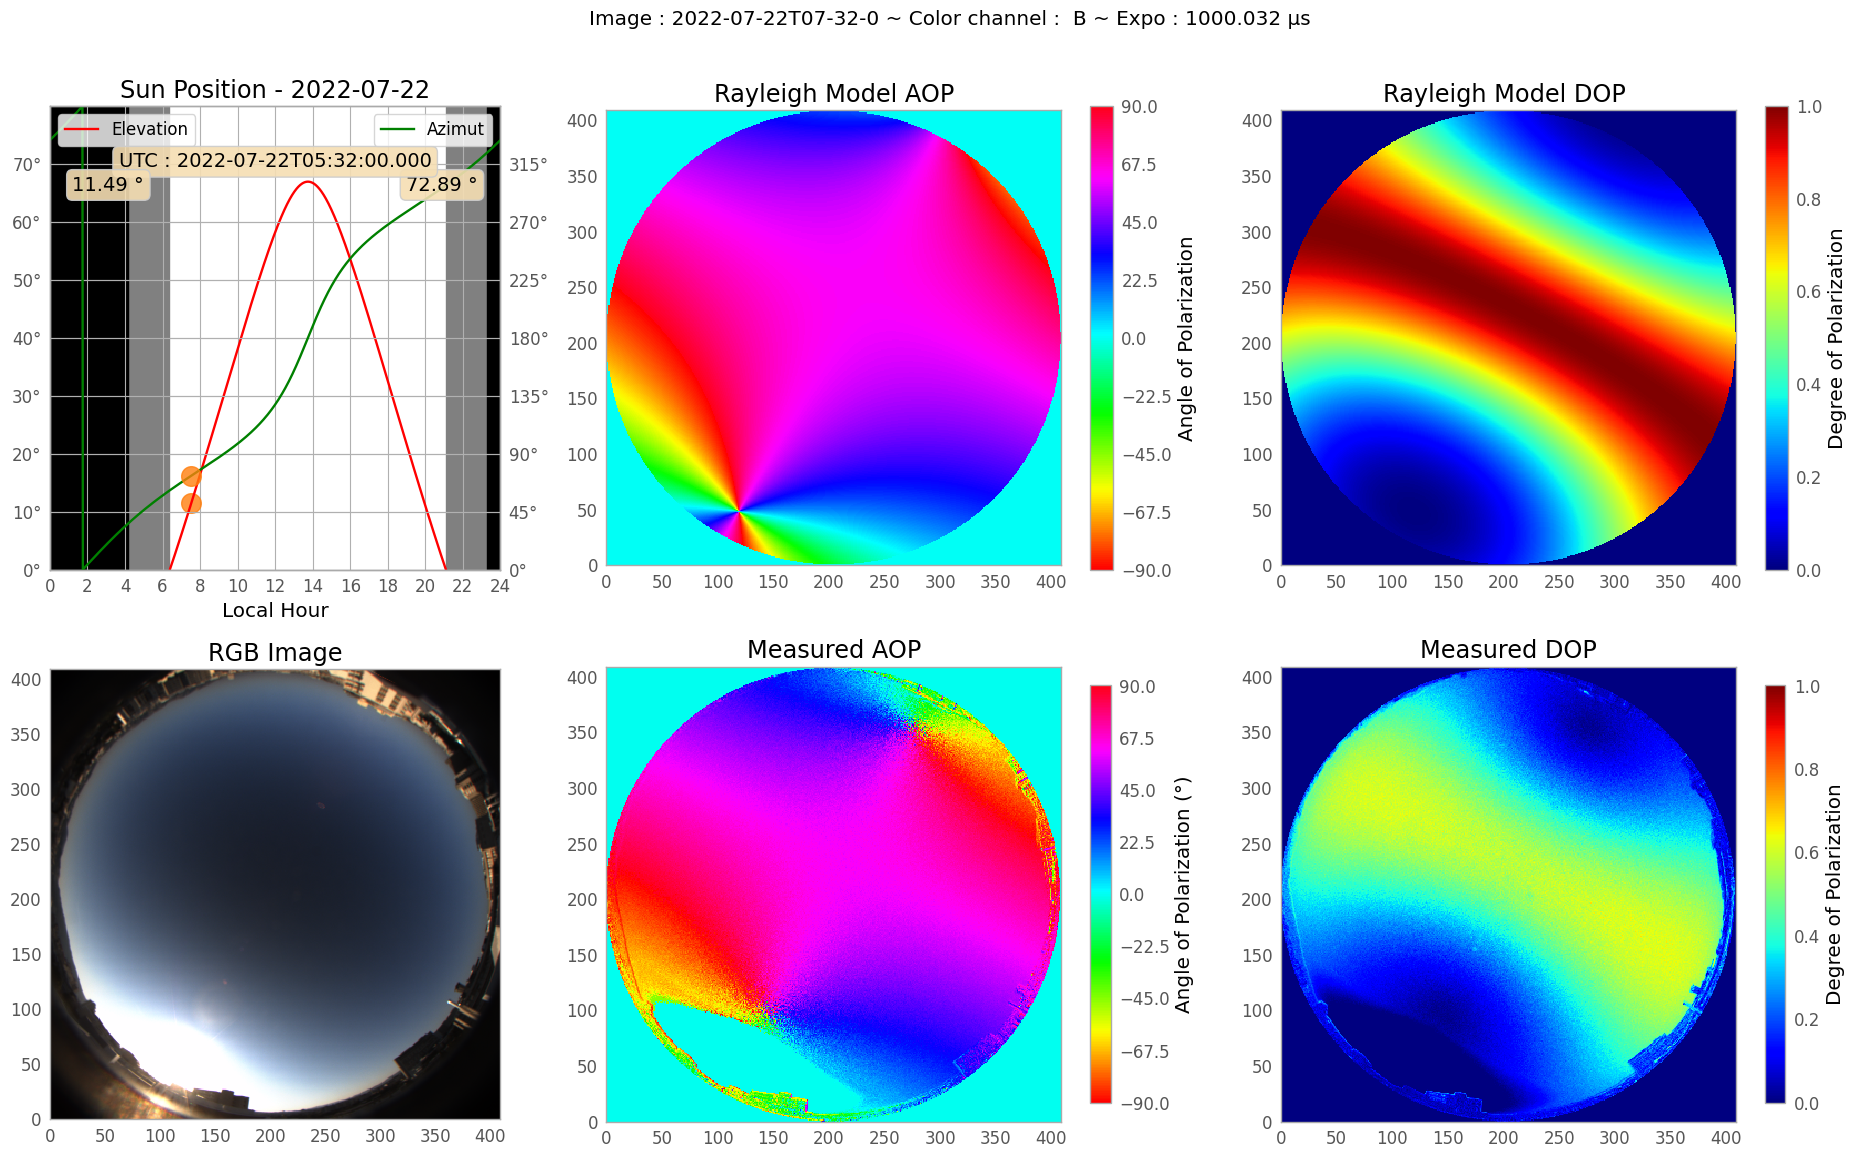

In [20]:
U,Q,I,A,D,mafig=visualize(image_pola,save=False)
chainetps=image_pola[2]
print(chainetps)
print(limit_Zenith_Angle)

# Calculation of AOP/DOP figure and values for each color, with Rayleigh simulation

In [21]:
def AOP_DOP_process_save_and_figure(image_pola,save=True,sat_level=65500):
    verbose_text=False
    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    type_image=image_pola[3]
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps)
    
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')
    
    
    chemin_enreg=out_path+chainedate+'/'
    if save:
        if not os.path.exists(chemin_enreg):
            try:
                os.mkdir(chemin_enreg)
            except Exception as e:print(e)
        #if os.path.exists(chemin_enreg+chainetps):return [None]
        if not os.path.exists(chemin_enreg+chainetps):
            try:
                os.mkdir(chemin_enreg+chainetps)
            except Exception as e:print(e)
        np.save(chemin_enreg+chainetps+"/image.npy",image)

    #Export Image Matlab format
    mdict = { 'Image' : image }
    file_path = os.path.join(chemin_enreg, chainetps + "/")
    #print(file_path)
    if save:savemat(file_path+"Image.mat", mdict)    
    
    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])

    # Here we want to calculate the "average angle" seen at the center of a macropixel. 
    # We know the orientations of each sub-pixel (theta, alpha). However, a simple average 
    # does not work for finding the "central" orientation. For instance, the "average" between 
    # two 2D vectors with angles 45° and 315° would "actually" be 0°, but the arithmetic mean of
    # the two angles is 180°. Here, we encounter the same problem when transitioning from -π to π 
    # with numerical artifacts. To avoid this, we convert back to Cartesian coordinates and use atan2.    
            
    if verbose_text:print("Creation figure ...")
    fig,(ax0,ax2,ax3)=plt.subplots(3,4,figsize=(24,20),gridspec_kw={'width_ratios':[1.2,1.2,1.2,1.2]})
    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Expo : "+str(expo)+" µs")
    
    
    if verbose_text:print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    ##########################################################################
    # cv2 replaced by np.stack
    # imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')
    imageRGB = (np.stack([a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
    ##########################################################################

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax0[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax0[1],shrink=0.9)
    ax0[0].set_aspect('equal')
    #ax2[0].imshow(cv2.cvtColor((imageRGB.astype('float32')/255.0).astype('uint8'), cv2.COLOR_BGR2RGB))
    #ax2[0].grid(False)        
    d=np.pi/180
    
    #Convention ZXY
    r = R.from_matrix(rot_mat)
   
            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    if verbose_text:print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    if verbose_text:print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
    #print(x_sol,y_sol,f,Sun_rot[0],Sun_rot[1],x_0,y_0)
    #print(rot_mat)
    #print(Sun_rot_cart)
                
    ax0[0].set_title("RGB Image")                 

    #os.mkdir(chemin_enreg)
    #os.mkdir(chemin_enreg+chainetps)
    
    if verbose_text:print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax0[1])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
    
    #Export Sun Matlab format
    mdict = { 'Psi_sun' : Psi_sun, 'Theta_sun' : Theta_sun}
    file_path = os.path.join(chemin_enreg, chainetps + "/")
    #print(file_path)
    if save:savemat(file_path+"Sun_pos.mat", mdict)
    

    for couleur in range(4):
        # Processing AOP and DOP for each color and saving it, and plot it

        #put a Nan Value on zones where at least one pixels of macropixel was saturated
        sat_zone=((image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]>sat_level) | 
                  (image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]>sat_level) |
                  (image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]>sat_level) |
                  (image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]>sat_level))

        
        #AOP values calculation
        Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
        ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
        ksi[theta_mini>limit_Zenith_Angle]=np.nan    
        ksi[sat_zone]=np.nan
        #getting right subfigure to plot it
        if couleur==0 or couleur==1 :
            ax_coul_aop=[ax2,ax3][couleur][0]
            ax_coul_dop=[ax2,ax3][couleur][1]
            if verbose_text:print(couleur)
        if couleur==2 or couleur==3 :
            ax_coul_aop=[ax2,ax3][couleur-2][2]
            ax_coul_dop=[ax2,ax3][couleur-2][3]
            if verbose_text:print(couleur)
        #ax_coul
        
        #save AOP value
        if save:np.save(chemin_enreg+chainetps+"/AOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",ksi)
          
        #Save AoP in matlab format : .mat
        mdict = { 'AOP_'+str(["R","Gr","Gb","B"][couleur]) : ksi}
        file_path = os.path.join(chemin_enreg, chainetps + "/")
        #print(file_path)
        if save:savemat(file_path+"AOP_"+str(["R","Gr","Gb","B"][couleur])+".mat", mdict)
        
        #Plot it
        if verbose_text:print("plot aop image...")
        cmap_hsv = plt.cm.hsv  # You can use any colormap you prefer
        cmap_hsv.set_bad('black', alpha=1.0)
        pcm1=ax_coul_aop.pcolormesh(ksi,cmap=cmap_hsv,vmin=-90.0, vmax=90.0)
        ax_coul_aop.set_title("Measured AOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbar=fig.colorbar(pcm1,ax=ax_coul_aop,shrink=0.9)
        cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
        cbar.set_label("Angle of Polarization (°)")
        #ax_coul_aop.invert_yaxis()

        if verbose_text:print("plot dop image...")
        # DOP values calculation
        DOP_dofp=np.hypot(Q,U)/I 
        DOP_dofp[theta_mini>limit_Zenith_Angle]=np.nan
        DOP_dofp[sat_zone]=np.nan
        
        #save it
        if save:np.save(chemin_enreg+chainetps+"/DOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",DOP_dofp)
        
        #Save DoP in matlab format : .mat
        mdict = { 'DOP_'+str(["R","Gr","Gb","B"][couleur]) : DOP_dofp}
        file_path = os.path.join(chemin_enreg, chainetps + "/")
        if save:savemat(file_path+"DOP_"+str(["R","Gr","Gb","B"][couleur])+".mat", mdict)
        
        #plot it
        # Create a custom colormap with black for NaN values
        cmap_jet = plt.cm.jet  # You can use any colormap you prefer
        cmap_jet.set_bad('black', alpha=1.0)
        pcm3=ax_coul_dop.pcolormesh(np.minimum(DOP_dofp,1),cmap=cmap_jet,vmin=0.0, vmax=1.0)
        ax_coul_dop.set_title("Measured DOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbardop=fig.colorbar(pcm3,ax=ax_coul_dop,shrink=0.9)
        pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
        cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
        cbardop.set_label("Degree of Polarization")
          
        ax_coul_aop.axis('scaled')
        ax_coul_dop.axis('scaled')

            
    if verbose_text:print("plot simul rayleigh...")
    #Show rayleigh simulation and save its values
    #AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,
    Theta=theta,rot_mat=rot_mat,limit_Zenith_Angle=limit_Zenith_Angle,out_zone=np.nan)#orientation_pixels_ENU=orientation_ENU)


          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)

    ax0[2].axis('scaled')
    ax0[3].axis('scaled')
    cbarrgb.remove()

    #save all data values in a folder        
    if save:np.save(chemin_enreg+chainetps+"/AOP_s.npy",AOP_s)
    if save:np.save(chemin_enreg+chainetps+"/DOP_s.npy",DOP_s)
    if save:np.save(chemin_enreg+chainetps+"/expo.npy",expo)
    
    
    if save:np.savetxt(chemin_enreg+chainetps+"/time.npy",list(map(int,chainetps[:-1].split('T')[0].split('-')+chainetps[:-1].split('T')[1].split('-'))),delimiter=',',fmt="%d") # ['YYYY', 'MM', 'DD', 'HH', 'mm', 'ss/']
    if verbose_text:print("Sauv fig...")
    if save:plt.savefig(chemin_enreg+chainetps+"/fig.png")
    if not save:plt.show()
    plt.close()
  
    return [chainedate+'/'+chainetps,chainetps,chaineheure[0],chaineheure[1],chaineheure[2],chainedate,Psi_sun,Theta_sun,Ha_sun,
                        Dec_sun,expo,type_image]


# Run this code here to process all the images in the directory defined by inpath and saved in the directory defined by outpath

In [22]:
#for i in range(len(dirs_files)):
for i in range(2):
    print(i, end=" ")
    print(dirs_files[i])
    images_pola=np.load(in_path+dirs_files[i],allow_pickle=True)
    tic=time.time()
#    liste_jour=sorted_filenames_dict[key]
    #partial_process_directory_1 = partial(process_directory_1, RGB_HSV_conv=True,image_size=50)
    #results=AOP_DOP_process_save_and_figure(image_pola)
    num_processes=2
    results = (p_map(AOP_DOP_process_save_and_figure ,images_pola,num_cpus=num_processes,tqdm=tqdm))
#results = np.array([sublist for sublists in results for sublist in sublists if sublist is not None])
#np.save(out_path+key+"_raw.npy",results)
    print("Elapsed Time : ",time.time()-tic)
    #np.array(results).shape
    print("Results shape:", np.array(results).shape)
    #print(type(results))
    
    #assert len(results) == 12, f"Expected 12 values, got {len(results)}"
    
    # Sample data for each column

    #Store datas in csv table
    # Specify the file name
    file_name = out_path+dirs_files[i].split("_")[0]+'.csv'

    # Write data to the CSV file
    with open(file_name, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write header row
        writer.writerow(['Image_folder_path', 'Timestamp', 'Hour_Local','Minute_Local','Second_Local', 
                         'Date', 'Sun_azimuth', 'Sun_zenith_angle', 'Sun_hour_angle', 'Sun_declination', 
                         'Camera_exposure_time','Image_type'])

        # write the single row
        writer.writerow(results)

            
    print(f"Data saved to {file_name}")
    print("\n" * 3)
    
    #print(f"Data saved to {file_name}")
    #print(" ")
    #print(" ")
    #print(" ")    

0 2022-07-22_raw.npy


 74%|██████████████████████████████▏          | 575/780 [11:17<04:01,  1.18s/it]


InterruptedError: [Errno 4] Interrupted system call

In [30]:
eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
expo=image_pola[1] 
chainetps=image_pola[2]
type_image=image_pola[3]
(Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
(Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps)
    
chaineheure=chainetps.split("T")[1].split("-")
chainedate=chainetps.split('T')[0]
heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
image=image_pola[0].astype('int64')

results=[chainedate+'/'+chainetps,chainetps,chaineheure[0],chaineheure[1],chaineheure[2],chainedate,Psi_sun,Theta_sun,Ha_sun,
                        Dec_sun,expo,type_image]
    
file_name = out_path + dirs_files[0].split("_")[0] + '.csv'
print(file_name)

# Write data to the CSV file
with open(file_name, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write header row
    writer.writerow([
        'Image_folder_path', 'Timestamp', 'Hour_Local', 'Minute_Local', 'Second_Local',
        'Date', 'Sun_azimuth', 'Sun_zenith_angle', 'Sun_hour_angle', 'Sun_declination',
        'Camera_exposure_time', 'Image_type'
    ])

    # Write data rows
    #for row in results:
    #    writer.writerow(row)
        
    # write the single row
    writer.writerow(results)

print(f"Data saved to {file_name}")
print("\n" * 3)


/Users/viollet/Downloads/dataverse_files/processed/2022-07-22.csv
Data saved to /Users/viollet/Downloads/dataverse_files/processed/2022-07-22.csv




